# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
# bands = "2-3-4"
bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"
# bands = "2-3-4-5-6-7"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [4]:
# points = "4"
points = "15"
# points = "24"
# points = "42"

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [5]:
crop_mask = True
#crop_mask = False

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [6]:
#impute_manual = True
impute_manual = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [7]:
#weighted_avg = True
weighted_avg = False

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [8]:
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

### Unchanging parmaters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [9]:
country_code = "ZMB"
num_features = 1000

# # same start and end years because we need the same time ranges for both satellites.
# year_start = 2015
# year_end = 2021

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
year_end = 2018

data_dir = f"/capstone/cropmosaiks/data/"
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

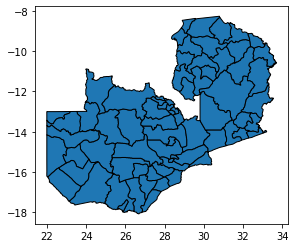

In [10]:
country_shp = geopandas.read_file(f'{data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [11]:
crop_df = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [12]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [13]:
list(set(country_districts) - set(crop_districts))

[]

In [14]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [15]:
weights = pd.read_feather(f"{data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

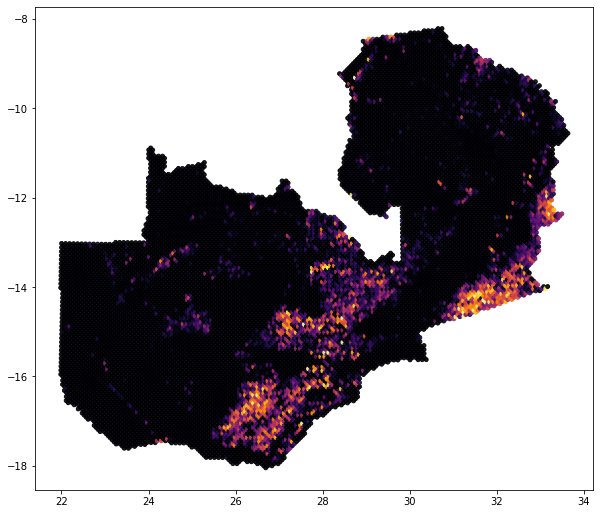

In [16]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [17]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

In [18]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{data_dir}/features/{satellite}/{feature_file_name}_{yr}.feather")
    
    if (yr == 2013) & (satellite == "landsat-8-c2-l2"):
        features_x = features_x[features_x.month > 9]
    elif (yr == 2015) & (satellite == "sentinel-2-l2a"):
        features_x = features_x[features_x.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")
    
    


Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2015.feather
feature.shape (9641, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2016.feather
feature.shape (145645, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2017.feather
feature.shape (262443, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2018.feather
feature.shape (411433, 1004)
Appending: 2018



In [19]:
features = features_raw.copy()

In [20]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [21]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [22]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [23]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [24]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

In [25]:
features

,lon,lat,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc
0,21.981760,-14.016935,2016,NaN,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,3.532144,3.849683,4.034249,4.161150,3.833862,NaN,3.656577,0.0
1,21.981760,-14.016935,2017,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,NaN,3.432352,3.232895,3.582984,3.557588,3.906777,3.954087,NaN,3.663198,0.0
2,21.981760,-14.016935,2018,0.0,NaN,NaN,0.0,0.0,0.0,0.0,...,3.210268,3.334542,3.225121,3.383499,3.428070,3.969848,4.198930,NaN,NaN,0.0
3,21.982866,-15.954329,2016,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,5.227335,NaN,5.875107,5.971619,6.791008,7.082443,6.455033,0.0
4,21.982866,-15.954329,2017,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,3.161662,3.721432,3.467443,3.776038,4.729180,4.564546,6.165408,5.689834,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45169,33.591399,-10.608472,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,2.364809,2.503003,2.644261,3.173683,3.614553,3.981074,4.017320,2.702897,0.0
45170,33.591399,-10.608472,2018,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,2.689727,2.751935,2.925664,3.120681,3.623976,3.651123,4.081519,NaN,0.0
45171,33.635833,-10.562597,2016,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,3.033279,3.232837,NaN,3.628088,NaN,NaN,NaN,0.0
45172,33.635833,-10.562597,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,2.434795,2.762295,3.003347,3.182618,3.465032,3.968551,3.696415,2.083110,0.0


### Mask croppped regions

In [26]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [27]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [28]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [29]:
# Drop the redundant independent lon and lat columns now that they are in a geometry column
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

In [30]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
# features

In [31]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

### Correct column names and drop geometry

In [32]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
points = features.copy()
points = features[['geometry']]
features = features.drop(['geometry'], axis = 1)
#features

In [33]:
features

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,district
0,2016,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,4.199941,3.946593,5.302142,5.075759,5.198160,5.814113,NaN,NaN,0.052945,Kalabo
1,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.395471,3.270982,3.856683,3.446999,3.961444,5.840712,NaN,NaN,0.052945,Kalabo
2,2018,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.756262,3.081625,2.996627,3.409674,3.650143,4.191209,NaN,NaN,0.052945,Kalabo
3,2016,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.601957,2.582440,3.082735,3.080645,2.787193,2.986427,NaN,NaN,0.038073,Kalabo
4,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.671852,2.539397,2.607912,2.617281,2.629002,3.200967,NaN,NaN,0.038073,Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13861,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.416423,3.540768,3.925379,4.489418,4.608852,4.370772,4.350643,3.790740,0.047591,Isoka
13862,2018,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.190162,3.374496,3.612117,3.843697,4.330680,4.903593,4.876778,NaN,0.047591,Isoka
13863,2016,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,NaN,2.746311,3.052905,NaN,3.990541,NaN,NaN,NaN,0.000595,Isoka
13864,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.675864,2.812651,2.839970,3.716929,3.984487,4.295646,3.502681,6.264046,0.000595,Isoka


### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [34]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [35]:
%%time
if impute_manual:
    print(f'Starting with\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with year district group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with district group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['year'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with year group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

CPU times: user 8.25 s, sys: 3.46 s, total: 11.7 s
Wall time: 11.7 s


In [36]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# impute_simple = True
# # # impute_simple = False

# # # impute_iterative = True
# impute_iterative = False

# if impute_simple:
#     features = features.set_index(['year', 'district'])
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imputer.fit_transform(features)
#     features[:] = imputer.transform(features)
#     features = features.reset_index()
# elif impute_iterative:
#     imputer = IterativeImputer(max_iter=2, random_state=0)
#     imputer.fit_transform(features)
#     features[:] = imputer.transform(features)
#     features = features.reset_index()
# else:
#     features = features.fillna(0).reset_index()

### Save copy of completed data 

In [37]:
features_copy = features.copy()
features_copy['geometry'] = points.geometry

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [38]:
features.columns

Index(['year', 'district', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '999_4', '999_5', '999_6', '999_7', '999_8', '999_9', '999_10',
       '999_11', '999_12', 'crop_perc'],
      dtype='object', length=12003)

In [39]:
var_cols = features.columns[1:-2].values.tolist()
features.columns[1:-2]

Index(['district', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8',
       '0_9',
       ...
       '999_2', '999_3', '999_4', '999_5', '999_6', '999_7', '999_8', '999_9',
       '999_10', '999_11'],
      dtype='object', length=12000)

In [40]:
%%time
if weighted_avg:
    features_summary = (
        features
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
else:
    features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

CPU times: user 2.02 s, sys: 439 ms, total: 2.46 s
Wall time: 2.45 s


### Join crop data

In [41]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [42]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())
# features_summary

## Model

In [43]:
model_year = features_summary[features_summary.year.isin([
   2014,
   2015,
   2016,
   2017,
   2018,
])]

### Define `x's` and `y's`

In [44]:
x_all = model_year.drop([
    'district', 
    'year', 
    'yield_mt',
    "crop_perc"
], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(model_year.yield_mt.to_numpy() + 1)

### Split into train and test sets

In [45]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [46]:
print("Total N: ", len(x_all), "\n", 
      "Train N: ", len(x_train), "\n",
      "Test  N: ", len(x_test), sep = "")

Total N: 216
Train N: 172
Test  N: 44


### Train model

In [47]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

### Validation set $R^2$ performance

In [48]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.57


### Train set

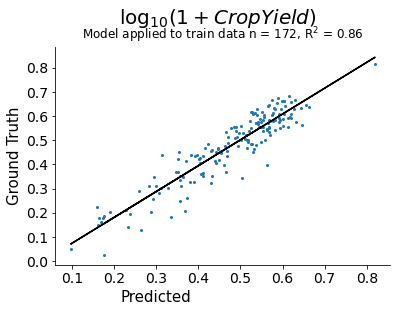

In [49]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [50]:
print(f"Training R^2 = {r2_score(y_train, y_pred):0.2f}\nPearsons R = {pearsonr(y_pred, y_train)[0]:0.2f}") 

Training R^2 = 0.86
Pearsons R = 0.93


### Test set

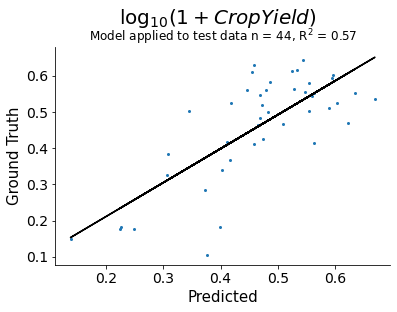

In [51]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [52]:
print(f"Testing set R^2 = {r2_score(y_test, y_pred):0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.57
Testing set pearsons R = 0.76


### Plot the fitted features

In [53]:
pred_features = features_copy.copy()

In [54]:
x_all = pred_features.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [55]:
pred_features = geopandas.GeoDataFrame(pred_features)

In [56]:
pred_features['fit'].mask(pred_features['crop_perc']==0, 0, inplace=True)
# pred_features.loc[pred_features["crop_perc"] == 0, "fit"] = 0   ### Does same thing but differently

In [57]:
# pred_features = pred_features[pred_features.crop_perc > 0].reset_index(drop = True)

In [58]:
pred_features['fit'].mask(pred_features['fit'] > 2, 0, inplace=True)

In [59]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

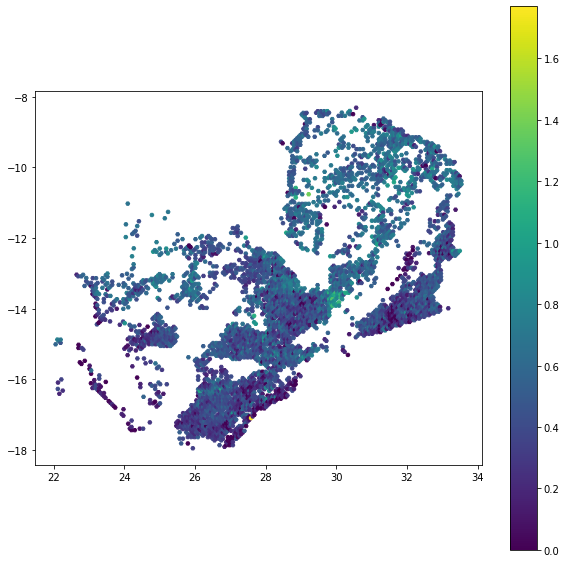

In [60]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

# Predict Crop Yields for years 2020-2021 in Zambia

In [61]:
year_start_19 = 2019
year_end_21 = 2021

In [62]:
features_raw_19_21 = geopandas.GeoDataFrame()

for yr in range(year_start_19, year_end_21 + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x_20_21 = pd.read_feather(f"{data_dir}/features/{satellite}/{feature_file_name}_{yr}.feather")
    
    if (yr == 2019):
        features_x_20_21 = features_x_20_21[features_x_20_21.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw_19_21 = pd.concat([features_raw_19_21, features_x_20_21], axis=0)
    
    print("feature.shape", features_raw_19_21.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2019.feather
feature.shape (36181, 1004)
Appending: 2019

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2020.feather
feature.shape (170171, 1004)
Appending: 2020

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2021.feather
feature.shape (312155, 1004)
Appending: 2021



In [63]:
features_raw_19_21

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,lon,lat,year,month
118371,0.000000,0.0,0.000002,0.0,1.833059,1.727647,2.525179,4.906328,1.336910,0.000000,...,1.409258,2.834173,0.000000,2.792270,2.224376,5.953320,23.257446,-17.514316,2019,10
118372,0.000000,0.0,0.000000,0.0,1.151525,1.141299,1.771850,3.514230,0.770234,0.000000,...,1.280059,2.380470,0.000000,2.363912,1.990462,4.772194,23.397575,-17.562035,2019,10
118373,0.000000,0.0,0.000063,0.0,1.790929,0.697424,2.010443,4.878084,1.803570,0.000000,...,1.554504,3.064397,0.000000,2.680188,1.881115,6.317649,23.351457,-17.516070,2019,10
118374,0.000000,0.0,0.000000,0.0,1.658242,2.477856,2.758159,4.496065,0.734666,0.000000,...,1.245279,2.489157,0.000000,2.754281,2.464787,5.241578,23.399356,-17.471824,2019,10
118375,0.000000,0.0,0.000004,0.0,1.406328,1.012606,1.781649,4.008350,1.145699,0.000000,...,1.424687,2.642476,0.000003,2.494313,1.939198,5.306307,23.305363,-17.470097,2019,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141979,0.000000,0.0,0.009216,0.0,1.155844,0.753697,1.620376,3.298596,1.009549,0.000269,...,1.378712,2.428882,0.140030,2.167864,1.793354,4.696368,27.961818,-16.824366,2021,12
141980,0.001847,0.0,0.000000,0.0,1.340720,0.000000,0.025316,4.473474,4.024046,1.491714,...,2.181283,4.131331,0.000000,1.881098,0.402551,8.033893,27.915112,-16.869773,2021,12
141981,0.000000,0.0,0.001924,0.0,1.725992,0.862830,2.062856,4.740337,1.630505,0.000000,...,1.503541,2.969992,0.002498,2.658402,1.955957,6.134625,27.867971,-16.824784,2021,12
141982,0.000377,0.0,0.000000,0.0,1.563441,0.000000,0.020797,5.002697,4.372069,1.721459,...,2.263838,4.384971,0.000000,2.001821,0.484017,8.610841,27.821241,-16.870170,2021,12


In [64]:
features_20_21 = features_raw_19_21.copy()

In [65]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features_20_21['year'] = np.where(
    features_20_21['month'].isin([10, 11, 12]),
    features_20_21['year'] + 1, 
    features_20_21['year'])

features_20_21 = features_20_21[features_20_21['year'] <= year_end_21]

features_20_21.sort_values(['year', 'month'], inplace=True) 

In [66]:
features_20_21

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,lon,lat,year,month
0,0.0,0.0,2.451520,1.424920,0.000603,0.500550,0.000000,1.055071,0.000526,0.0,...,6.274560,1.886502,1.012565,0.000000,0.000761,0.000970,22.889560,-17.146227,2020,1
1,0.0,0.0,2.347848,2.568228,0.015396,0.043277,0.000000,1.061755,0.005835,0.0,...,6.455102,1.756476,0.496857,0.000000,0.014701,0.001913,22.887567,-17.236387,2020,1
2,0.0,0.0,2.531468,0.718114,0.000007,1.293223,0.000000,1.081120,0.000003,0.0,...,6.011026,1.881359,1.500975,0.000000,0.000000,0.000517,22.981395,-17.238286,2020,1
3,0.0,0.0,2.116175,0.151425,0.000072,1.457877,0.000000,0.818358,0.000000,0.0,...,5.228773,1.771339,1.681787,0.000000,0.000000,0.029372,22.935466,-17.192259,2020,1
4,0.0,0.0,2.502230,0.161712,0.000047,1.876241,0.000000,1.037609,0.000006,0.0,...,5.717872,1.874105,1.840157,0.000000,0.000000,0.003854,22.983343,-17.148115,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133985,0.0,0.0,0.000000,0.000000,0.422851,2.729465,2.807549,2.188542,0.000618,0.0,...,0.667505,1.358416,0.000000,1.961076,2.970599,2.736568,30.331441,-15.490564,2021,12
133986,0.0,0.0,0.000000,0.000000,0.431992,2.434322,2.543511,2.167801,0.003292,0.0,...,0.737120,1.424848,0.000000,1.961957,2.786206,2.830758,30.285618,-15.536390,2021,12
133987,0.0,0.0,0.000000,0.000000,0.796252,1.776357,2.176815,2.813458,0.249656,0.0,...,1.021591,1.871542,0.000000,2.159308,2.484037,3.689641,30.332893,-15.580818,2021,12
133988,0.0,0.0,0.000000,0.000000,0.898222,2.664230,2.845879,3.100143,0.064501,0.0,...,0.889648,1.788128,0.000000,2.268662,2.854889,3.686461,30.379994,-15.625335,2021,12


In [67]:
# filter month range
#features_20_21 = features_20_21[adm_features_20_21.month.isin(month_range)]

### Pivot wider
See the above **Pivot wider** chunk for explanation of this process

In [68]:
features_20_21 = features_20_21.set_index(['lon','lat', "year", 'month']).unstack()
features_20_21.columns = features_20_21.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`
See the above **Replace "inf" values with `NaN`** chunk for explanation of this process

In [69]:
features_20_21.replace([np.inf, -np.inf], np.nan, inplace=True)
features_20_21 = features_20_21.reset_index()
# features_20_21

### Attach crop weights
See the above **Attach crop weights** chunk for explanation of this process

#### Note:
Attaching crop weights to the 20-21 data is not necessary for creating  predictions for these years at the resolution of the features within the 1 kilometer. This column is dropped later before we produce predictions. Similarly to the reasoning behind summarizing the features to the administrative boundary level, adding crop weights to this dataframe is useful if you wanted to visalize the predicitons by district.

In [70]:
features_20_21 = features_20_21.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features_20_21 = features_20_21.drop(["geometry"], axis = 1)
# features_20_21

In [71]:
features_20_21

,lon,lat,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc
0,21.981760,-14.016935,2020,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.061103,2.959359,2.965519,3.023272,3.393588,4.035593,3.987380,NaN,3.575588,0.0
1,21.981760,-14.016935,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.374543,3.030129,2.949720,3.257521,3.554925,3.742572,3.253622,NaN,NaN,0.0
2,21.982866,-15.954329,2020,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022663,4.268951,4.381494,4.416975,4.512887,4.528296,6.711634,NaN,NaN,0.0
3,21.982866,-15.954329,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.935208,3.461454,3.726905,4.034325,4.066234,4.211470,4.266701,4.518088,NaN,0.0
4,21.983715,-13.926863,2020,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.003341,4.410058,4.420613,4.572869,4.798552,4.982535,6.502082,NaN,5.693221,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30233,33.589476,-10.518631,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,NaN,2.631809,2.824717,3.097642,3.144433,3.464318,3.998152,3.330421,NaN,0.0
30234,33.591399,-10.608472,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,0.049935,2.683461,NaN,2.851734,3.221783,3.530480,3.887140,9.084584,2.914841,0.0
30235,33.591399,-10.608472,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,NaN,2.643231,2.666830,2.883513,2.773937,3.391628,3.724069,3.695107,NaN,0.0
30236,33.635833,-10.562597,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,0.100428,2.852466,NaN,3.032688,3.325195,3.146947,3.649997,4.993696,3.639261,0.0


### Mask croppped regions

In [72]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features_20_21 = features_20_21[features_20_21.crop_perc > 0]
else:
    pass
# features_20_21

### Make "features" a `GeoDataFrame`
See the above **Make "features" a `GeoDataFrame`** chunk for explanation of this process

In [73]:
features_20_21 = geopandas.GeoDataFrame(
    features_20_21, 
    geometry = geopandas.points_from_xy(x = features_20_21.lon, y = features_20_21.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [74]:
#mn = 9
#yr = 2017
#feature = 999

#features[features.year == yr].plot(
#    column = f"{feature}_{mn}",
#    figsize = (10,10),
#    marker='H',
#    # legend = True,
#    markersize = marker_sz,
#)

### Drop 'lat' and 'lon' columns

In [75]:
features_20_21

,lon,lat,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,geometry
116,22.051999,-15.009698,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,POINT (22.05200 -15.00970)
117,22.051999,-15.009698,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.018314,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,NaN,0.052945,POINT (22.05200 -15.00970)
132,22.067024,-16.316749,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.197496,2.044670,2.198037,2.278311,2.464370,2.789879,NaN,NaN,0.007139,POINT (22.06702 -16.31675)
133,22.067024,-16.316749,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.391048,2.603598,2.940658,2.968242,2.988191,2.296002,2.669218,2.171998,0.007139,POINT (22.06702 -16.31675)
194,22.101409,-14.875582,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,2.359581,2.770979,2.791037,2.777612,2.765536,3.489497,NaN,NaN,0.038073,POINT (22.10141 -14.87558)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,33.498682,-10.520513,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,2.565184,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,NaN,0.008328,POINT (33.49868 -10.52051)
30224,33.541248,-10.384799,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,2.980647,NaN,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227,0.047591,POINT (33.54125 -10.38480)
30225,33.541248,-10.384799,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,2.854219,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,NaN,0.047591,POINT (33.54125 -10.38480)
30226,33.543133,-10.474650,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,...,2.777765,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,POINT (33.54313 -10.47465)


In [76]:
# Drop the redundant independent lon and lat columns now that they are in a geometry column
features_20_21 = features_20_21.drop(['lon', 'lat'], axis = 1)

In [77]:
features_20_21

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,geometry
116,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,POINT (22.05200 -15.00970)
117,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.018314,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,NaN,0.052945,POINT (22.05200 -15.00970)
132,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.197496,2.044670,2.198037,2.278311,2.464370,2.789879,NaN,NaN,0.007139,POINT (22.06702 -16.31675)
133,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.391048,2.603598,2.940658,2.968242,2.988191,2.296002,2.669218,2.171998,0.007139,POINT (22.06702 -16.31675)
194,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.359581,2.770979,2.791037,2.777612,2.765536,3.489497,NaN,NaN,0.038073,POINT (22.10141 -14.87558)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,2.565184,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,NaN,0.008328,POINT (33.49868 -10.52051)
30224,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,2.980647,NaN,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227,0.047591,POINT (33.54125 -10.38480)
30225,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,2.854219,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,NaN,0.047591,POINT (33.54125 -10.38480)
30226,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,2.777765,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,POINT (33.54313 -10.47465)


### Join features to country geometry

#### Note:
Adding the district to the 20-21 data is not necessary for creating feature-resolution predictions for these years. This column is dropped later before we produce predictions. Similarly to the reasoning behind summarizing the features to the administrative boundary level, adding districts to this dataframe is useful if you wanted to visalize the predicitons by district.

In [78]:
features_20_21 = features_20_21.sjoin(country_shp, how = 'left', predicate = 'within')
features_20_21

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,geometry,index_right
116,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
117,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
132,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.044670,2.198037,2.278311,2.464370,2.789879,NaN,NaN,0.007139,POINT (22.06702 -16.31675),NaN
133,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.603598,2.940658,2.968242,2.988191,2.296002,2.669218,2.171998,0.007139,POINT (22.06702 -16.31675),NaN
194,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.770979,2.791037,2.777612,2.765536,3.489497,NaN,NaN,0.038073,POINT (22.10141 -14.87558),Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,NaN,0.008328,POINT (33.49868 -10.52051),Isoka
30224,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227,0.047591,POINT (33.54125 -10.38480),Isoka
30225,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,NaN,0.047591,POINT (33.54125 -10.38480),Isoka
30226,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,POINT (33.54313 -10.47465),Isoka


<AxesSubplot:>

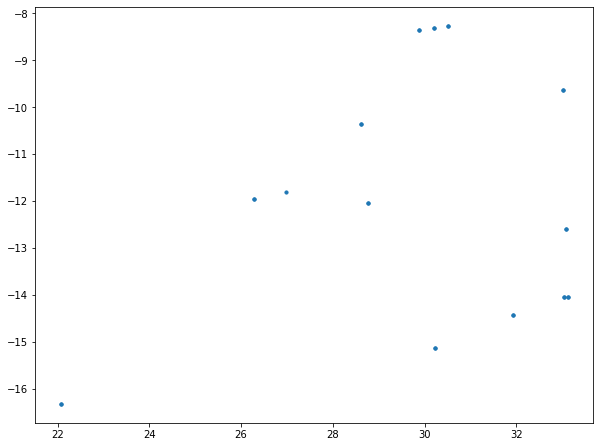

In [79]:
na = features_20_21[features_20_21.index_right.isna()]
na.plot(figsize = (10,10), markersize = 10)

In [80]:
# Drop NA's from the district column (called index_right) then rename the column index_right to district
features_20_21 = (
    features_20_21
    # drop NA values 
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
# make a copy of the features 
points = features_20_21.copy()
# save the geometries as an object to join them them later to the rows
points = features_20_21[['geometry']]
year = features_20_21[['year']]
# drop geometry column for 20/21 features
features_20_21 = features_20_21.drop(['geometry'], axis = 1)
features_20_21

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,district
0,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,Kalabo
1,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.018314,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,NaN,0.052945,Kalabo
2,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.359581,2.770979,2.791037,2.777612,2.765536,3.489497,NaN,NaN,0.038073,Kalabo
3,2021,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.765317,3.151427,3.394306,3.199576,2.595780,2.699855,2.933753,NaN,0.038073,Kalabo
4,2020,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.091311,4.222900,4.136757,4.597979,3.927488,3.461518,NaN,NaN,0.084474,Shangombo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9282,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,2.565184,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,NaN,0.008328,Isoka
9283,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,2.980647,NaN,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227,0.047591,Isoka
9284,2021,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,2.854219,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,NaN,0.047591,Isoka
9285,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,2.777765,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,Isoka


### Impute missing values
See the above **Impute missing values** chunk for explanation of this process

In [81]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features_20_21) * len(month_range) * num_features

In [82]:
%%time
if impute_manual:
    print(f'Starting with\n{(features_20_21.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features_20_21 = (
        features_20_21
        .fillna(features_20_21
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with year district group average\n{(features_20_21.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features_20_21 = (
        features_20_21
        .fillna(features_20_21
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with district group average\n{(features_20_21.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features_20_21 = (
        features_20_21
        .fillna(features_20_21
                .groupby(['year'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with year group average\n{(features_20_21.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
else:
    features_20_21 = features_20_21.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features_20_21)
    features_20_21[:] = imputer.transform(features_20_21)
    features_20_21 = features_20_21.reset_index()

CPU times: user 4.63 s, sys: 2.85 s, total: 7.47 s
Wall time: 7.48 s


### Save copy of completed data 

### **Optional for 2020 & 2021 features:** Summarise to administrative boundary level
See the above **Summarise to administrative boundary level** chunk for explanation of this process

This is optional for these features because these features are NOT going to be joined to crop data, because none is available for these years. The features for 2020 and 2021 are summarized to the administrative boundary level because that is the level of resolution of the crop data, and those features were joined with cop data to train the model. If a user is interested in sumamry statistics for the 2020-21 features, either in a table or a map, then summarizing to the administrative boundary level might be useful. Otherwise, summarizing these feature-level predicitions to the district-level is simply lowering the resolution of the data.

In [83]:
#features_20_21.columns

In [84]:
#var_cols = features_20_21.columns[1:-2].values.tolist()
#features_20_21.columns[1:-2]

In [85]:
#%%time
#if weighted_avg:
#    features_20_21_summary = (
#        features
#        .groupby(['year', 'district'], as_index=False)
#        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
#    )
#else:
#    features_20_21_summary = features_20_21.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [86]:
# do not need this step for the 20-21 feature data
#model_20_21 = features_20_21[features_20_21.year.isin([
#   2020,
#   2021,
#])]

### In order to define the x's for just the years 20-21, we need to drop the same columns we dropped for the features for all years, but we do not drop the `yield_mt` column because it does not exist for these years.

### First, split prediction years into 2020 and 2021 dataframes to predict values for each year independently, since we take the year column out of the dataframe before we predict, and we don't care about plotting the scatterplot 

In [87]:
# commented out because we want to predict only once for 20/21 
# choice = dframe[(dframe['field'] == field_filter)
#features_20 = features_20_21[features_20_21['year'] == 2020]
#features_21 = features_20_21[features_20_21['year'] == 2021]

In [88]:
features_20_21

,year,district,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc
0,2020,Kalabo,1.176716e-07,0.000000e+00,9.793628e-07,0.000000,0.0,0.000000e+00,0.0,0.0,...,0.049729,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,4.216793,3.776752,0.052945
1,2021,Kalabo,1.176716e-07,4.276557e-07,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,...,2.629534,3.018314,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,3.776752,0.052945
2,2020,Kalabo,1.176716e-07,0.000000e+00,9.793628e-07,0.000000,0.0,0.000000e+00,0.0,0.0,...,0.203384,2.359581,2.770979,2.791037,2.777612,2.765536,3.489497,4.216793,3.776752,0.038073
3,2021,Kalabo,1.176716e-07,4.276557e-07,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,...,2.341630,2.765317,3.151427,3.394306,3.199576,2.595780,2.699855,2.933753,3.776752,0.038073
4,2020,Shangombo,1.176716e-07,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,...,0.014090,4.091311,4.222900,4.136757,4.597979,3.927488,3.461518,4.216793,3.776752,0.084474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9282,2021,Isoka,1.176716e-07,4.276557e-07,0.000000e+00,0.000001,0.0,0.000000e+00,0.0,0.0,...,1.458901,2.565184,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,3.776752,0.008328
9283,2020,Isoka,1.176716e-07,4.276557e-07,9.793628e-07,0.000000,0.0,7.134116e-07,0.0,0.0,...,0.083904,2.980647,3.582565,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227,0.047591
9284,2021,Isoka,1.176716e-07,4.276557e-07,0.000000e+00,0.000001,0.0,0.000000e+00,0.0,0.0,...,1.458901,2.854219,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,3.776752,0.047591
9285,2020,Isoka,1.176716e-07,4.276557e-07,9.793628e-07,0.000000,0.0,7.134116e-07,0.0,0.0,...,0.038843,2.777765,3.582565,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595


In [89]:
# we can drop year here because each row reps 1 year due to the way we processed the data, so we dont need the col anymore, the rows already are set up that way
x_20_21 = features_20_21.drop([
    'district', 
    'year', 
    "crop_perc"
], axis = 1)


In [90]:
x_20_21

,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,1.176716e-07,0.000000e+00,9.793628e-07,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,1.535540,0.049729,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,4.216793,3.776752
1,1.176716e-07,4.276557e-07,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,3.018364,2.629534,3.018314,3.186715,3.561495,3.665818,3.582959,4.434658,5.138444,3.776752
2,1.176716e-07,0.000000e+00,9.793628e-07,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,1.535540,0.203384,2.359581,2.770979,2.791037,2.777612,2.765536,3.489497,4.216793,3.776752
3,1.176716e-07,4.276557e-07,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,2.230949,2.341630,2.765317,3.151427,3.394306,3.199576,2.595780,2.699855,2.933753,3.776752
4,1.176716e-07,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.066513,0.014090,4.091311,4.222900,4.136757,4.597979,3.927488,3.461518,4.216793,3.776752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9282,1.176716e-07,4.276557e-07,0.000000e+00,0.000001,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,2.434031,1.458901,2.565184,3.064676,3.228524,3.227988,3.854056,4.062489,3.369599,3.776752
9283,1.176716e-07,4.276557e-07,9.793628e-07,0.000000,0.0,7.134116e-07,0.0,0.0,0.0,0.0,...,1.535540,0.083904,2.980647,3.582565,3.267686,3.934907,4.015057,4.683146,4.756311,3.883227
9284,1.176716e-07,4.276557e-07,0.000000e+00,0.000001,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,2.440303,1.458901,2.854219,2.828540,3.242651,3.559826,4.235030,4.402984,4.204847,3.776752
9285,1.176716e-07,4.276557e-07,9.793628e-07,0.000000,0.0,7.134116e-07,0.0,0.0,0.0,0.0,...,1.535540,0.038843,2.777765,3.582565,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903


In [91]:
#x_20_21_copy = x_20_21.copy

In [92]:
pred_20_21 = np.maximum(ridge_cv_random.predict(x_20_21), 0)

#len(y_pred_20_21) # length of the array y_pred_20_21 is the same as the number of rows in the feature data fed into the model

pred_20_21

array([0.        , 0.61916262, 0.25334467, ..., 0.30642338, 0.0528001 ,
       0.32986893])

In [93]:
type(pred_20_21)

numpy.ndarray

In [94]:
# features_20_21_copy = features_20_21.copy()
# features_20_21_copy['geometry'] = points.geometry
# features_20_21_copy['year'] = year
# # check that the geometries were properly rejoined
# features_20_21_copy

In [108]:
pred_20_21_gdf = geopandas.GeoDataFrame(pred_20_21)
pred_20_21_gdf

,0
0,0.000000
1,0.619163
2,0.253345
3,0.899311
4,0.000000
...,...
9282,0.528458
9283,0.069708
9284,0.306423
9285,0.052800


In [109]:
# rename column for predictions 
pred_20_21_gdf['pred_yields'] = pred_20_21_gdf[0]
pred_20_21_gdf

,0,pred_yields
0,0.000000,0.000000
1,0.619163,0.619163
2,0.253345,0.253345
3,0.899311,0.899311
4,0.000000,0.000000
...,...,...
9282,0.528458,0.528458
9283,0.069708,0.069708
9284,0.306423,0.306423
9285,0.052800,0.052800


In [110]:
pred_20_21_gdf = pred_20_21_gdf.drop([0], axis = 1)
pred_20_21_gdf

,pred_yields
0,0.000000
1,0.619163
2,0.253345
3,0.899311
4,0.000000
...,...
9282,0.528458
9283,0.069708
9284,0.306423
9285,0.052800


In [111]:
pred_20_21_gdf_copy = pred_20_21_gdf.copy()
pred_20_21_gdf_copy['geometry'] = points.geometry
pred_20_21_gdf_copy['year'] = year
# check that the geometries were properly rejoined
pred_20_21_gdf_copy

,pred_yields,geometry,year
0,0.000000,POINT (22.05200 -15.00970),2020
1,0.619163,POINT (22.05200 -15.00970),2021
2,0.253345,POINT (22.10141 -14.87558),2020
3,0.899311,POINT (22.10141 -14.87558),2021
4,0.000000,POINT (22.11478 -16.27280),2020
...,...,...,...
9282,0.528458,POINT (33.49868 -10.52051),2021
9283,0.069708,POINT (33.54125 -10.38480),2020
9284,0.306423,POINT (33.54125 -10.38480),2021
9285,0.052800,POINT (33.54313 -10.47465),2020


## Plot Predicted Crop Yields by Year

In [117]:
pred_yield_20 = pred_20_21_gdf_copy[pred_20_21_gdf_copy.year == 2020]
pred_yield_21 = pred_20_21_gdf_copy[pred_20_21_gdf_copy.year == 2021]

<AxesSubplot:>

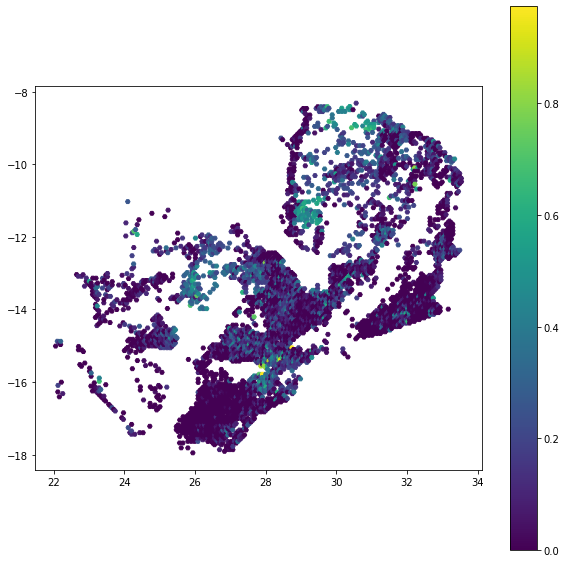

In [122]:
pred_yield_20.plot(figsize= (10,10),
                  marker = 'H',
                  legend = True,
                  markersize = 20,
                  column = "pred_yields")

<AxesSubplot:>

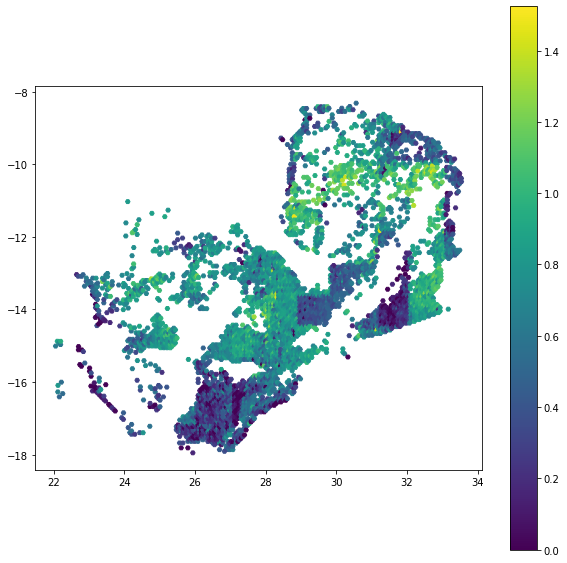

In [123]:
pred_yield_21.plot(figsize= (10,10),
                  marker = 'H',
                  legend = True,
                  markersize = 20,
                  column = "pred_yields")

## Yield and Residual Plots
### Create data frame 

In [ ]:
x_all = features_20_21.drop([
    'district', 
    'year', 
    'yield_mt',
    'crop_perc'
], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
#demean by location
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

### Crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

### Log transform crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

### Log crop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### District residuals

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

### Difference from the Mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

In [ ]:
for yr in range(year_start+1, year_end+1):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's R: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's R: {pearson_r[0]:.2f}", sep = "")